# Quick start guide
This notebook serves as an example of how to train a simple model using pytorch and the ready-to-train AI4Arctic challenge dataset. Initially, a dictionary, 'train_options', is set up with relevant options for both the example U-Net Convolutional Neural Network model and the dataloader. Note that the weights of the U-Net will be initialised at random and therefore not deterministic - results will vary for every training run. Two lists (dataset.json and testset.json) include the names of the scenes relevant to training and testing, where the former can be altered if desired. Training data is loaded in parallel using the build-in torch Dataset and Dataloader classes, and works by randomly sampling a scene and performing a random crop to extract a patch. Each batch will then be compiled of X number of these patches with the patch size in the 'train_options'. An obstacle is different grid resolution sizes, which is overcome by upsampling low resolution variables, e.g. AMSR2, ERA5, to match the SAR pixels. A number of batches will be prepared in parallel and stored until use, depending on the number of workers (processes) spawned (this can be changed in 'num_workers' in 'train_options'). The model is trained on a fixed number of steps according to the number of batches in an epoch, defined by the 'epoch_len' parameter, and will run for a total number of epochs depending on the 'epochs' parameter. After each epoch, the model is evaluated. In this example, a random number of scenes are sampled among the training scenes (and removed from the list of training scenes) to act as a validation set used for the evaluation. The model is evaluated with the metrics, and if the current validation attempt is superior to the previous, then the model parameters are stored in the 'best_model' file in the directory.

The models are scored on the three sea ice parameters; Sea Ice Concentration (SIC), Stage of Development (SOD) and the Floe size (FLOE) with the $R²$ metric for the SIC, and the weighted F1 metric for the SOD and FLOE. The 3 scores are combined into a single metric by taking the weighted average with SIC and SOD being weighted with 2 and the FLOE with 1.

Finally, once you are ready to test your model on the test scenes (without reference data), the 'test_upload' notebook will produce model outputs with your model of choice and save the output as a netCDF file, which can be uploaded to the AI4EO.eu website. The model outputs will be evaluated and then you will receive a score. 

This quick start notebook is by no means necessary to utilize, and you are more than welcome to develop your own data pipeline. We do however require that the model output is stored in a netcdf file with xarray.dataarrays titled '{scene_name}_{chart}', i.e. 3 charts per scene / file (see how in 'test_upload'). In addition, you are more than welcome to create your own preprocessing scheme to prepare the raw AI4Arctic challenge dataset. However, we ask that the model output is in 80 m pixel spacing (original is 40 m), and that you follow the class numberings from the lookup tables in 'utils' - at least you will be evaluated in this way. Furthermore, we have included a function to convert the polygon_icechart to SIC, SOD and FLOE, you will have to incorporate it yourself.

The first cell imports the necessary Python packages, initializes the 'train_options' dictionary, the sample U-Net options, loads the dataset list and select validation scenes.

In [1]:
# -- Built-in modules -- #
import gc
import os
import sys
from contextlib import nullcontext

# -- Environmental variables -- #
#os.environ['AI4ARCTIC_DATA'] = ''  # Fill in directory for data location.
#os.environ['AI4ARCTIC_ENV'] = ''  # Fill in directory for environment with Ai4Arctic get-started package. 


In [2]:
# -- Third-part modules -- #
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr
from tqdm.notebook import tqdm  # Progress bar
import mlflow
import mlflow.pytorch

# --Proprietary modules -- #
from functions_improvements import chart_cbar, r2_metric, f1_metric, compute_metrics  # Functions to calculate metrics and show the relevant chart colorbar.
from loaders_improvements import AI4ArcticChallengeDataset, AI4ArcticChallengeTestDataset, get_variable_options  # Custom dataloaders for regular training and validation.
from unet_improvements import UNet  # Convolutional Neural Network model
from utils import CHARTS, SIC_LOOKUP, SOD_LOOKUP, FLOE_LOOKUP, SCENE_VARIABLES, colour_str

train_options = {
    'model_codename': 'PizzaFunghi',
    'development': True,

    # -- Training options -- #
    'path_to_processed_data': os.environ['AI4ARCTIC_DATA'],  # Replace with data directory path.
    'path_to_env': '',  # Replace with environmment directory path.
    'lr': 0.0001,  # Optimizer learning rate.
    'epochs': 50,  # Number of epochs before training stop.
    'epoch_len': 500,  # Number of batches for each epoch.
    'patch_size': 256, # Size of patches sampled. Used for both Width and Height.
    'batch_size': 8,  # Number of patches for each batch.
    'loader_upsampling': 'nearest',  # How to upscale low resolution variables to high resolution.
    'loss_sic': 'classification', # Loss function for SIC, 'regression' or 'classification'.

    # -- Data prepraration lookups and metrics.
    'train_variables': SCENE_VARIABLES,  # Contains the relevant variables in the scenes.
    'charts': CHARTS,  # Charts to train on.
    'n_classes': {  # number of total classes in the reference charts, including the mask.
        'SIC': SIC_LOOKUP['n_classes'],
        'SOD': SOD_LOOKUP['n_classes'],
        'FLOE': FLOE_LOOKUP['n_classes']
    },
    'pixel_spacing': 80,  # SAR pixel spacing. 80 for the ready-to-train AI4Arctic Challenge dataset.
    'train_fill_value': 0,  # Mask value for SAR training data.
    'class_fill_values': {  # Mask value for class/reference data.
        'SIC': SIC_LOOKUP['mask'],
        'SOD': SOD_LOOKUP['mask'],
        'FLOE': FLOE_LOOKUP['mask'],
    },
    'get_metadata': True,  # Flag used in the dataloaders to get metadata.
    'resampling': True,  # Whether to resample the training data. Otherwise, the scene is randomly sampled.
    'path_to_data': 'misc/',  # Path to the data directory.
    'visualize_distribution': True,  # Whether to visualize the difference in distribution between the training, validation and test data.
    'difficult_locations':['CentralEast', 'NorthAndCentralEast',],  #  'CentralWest', 'SGRDIEA', 'SGRDIMID', 'SGRDIHA'],  # Locations to oversample as they are more difficult to learn.

    # -- Validation options -- #
    'chart_metric': {  # Metric functions for each ice parameter and the associated weight.
        'SIC': {
            'func': r2_metric,
            'weight': 2,
        },
        'SOD': {
            'func': f1_metric,
            'weight': 2,
        },
        'FLOE': {
            'func': f1_metric,
            'weight': 1,
        },
    },
    'num_val_scenes': 10,  # Number of scenes randomly sampled from train_list to use in validation.
    'validation_seed': 465,  # Seed used to sample the validation scenes. # TODO: optimize validation seed to better reflect the test distribution!
    'seed': 465,  # Seed used for the data loaders.

    # -- GPU/cuda options -- #
    'gpu_id': 0,  # Index of GPU. In case of multiple GPUs.
    'num_workers': 6,  # Number of parallel processes to fetch data.
    'num_workers_val': 1,  # Number of parallel processes during validation.
    
    # -- U-Net Options -- # now 3 lvls as in the paper
    # DIFF:
    # 1. run: 'unet_conv_filters': [16, 32, 32, 3],
    'unet_conv_filters': [16, 32, 32, 32, 32, 32, 32, 32],     # Number of filters in the U-Net.
    'conv_kernel_size': (3, 3),  # Size of convolutional kernels.
    'conv_stride_rate': (1, 1),  # Stride rate of convolutional kernels.
    'conv_dilation_rate': (1, 1),  # Dilation rate of convolutional kernels.
    'conv_padding': (1, 1),  # Number of padded pixels in convolutional layers.
    'conv_padding_style': 'zeros',  # Style of padding.
}

# change train options in development mode
if train_options['development']:
    train_options['epochs'] = 2
    train_options['epoch_len'] = 2
    train_options['batch_size'] = 2
    train_options['num_val_scenes'] = 2

# Get options for variables, amsrenv grid, cropping and upsampling.
get_variable_options = get_variable_options(train_options)
# To be used in test_upload.
%store train_options  

# Load training list.
with open(train_options['path_to_env'] + 'datalists/dataset.json') as file:
    train_options['train_list'] = json.loads(file.read())

# Select a random number of validation scenes with the same seed. Feel free to change the seed.et
np.random.seed(train_options['validation_seed'])
train_options['validate_list'] = np.random.choice(np.array(train_options['train_list']), size=train_options['num_val_scenes'], replace=False)
# Remove the validation scenes from the train list.
train_options['train_list'] = [scene for scene in train_options['train_list'] if scene not in train_options['validate_list']]

# Convert the original scene names to the preprocessed names.
train_options['train_list_extendedNames'] = train_options['train_list'].copy()
train_options['validate_list_extendedNames'] = train_options['validate_list'].copy()
train_options['train_list'] = [file[17:32] + '_' + file[77:80] + '_prep.nc' for file in train_options['train_list']]
train_options['validate_list'] = [file[17:32] + '_' + file[77:80] + '_prep.nc' for file in train_options['validate_list']]

print('Options initialised')


Stored 'train_options' (dict)
Options initialised


### CUDA / GPU Setup
This sets up the 'device' variable containing GPU information, and the custom dataset and dataloader.

GPU not available.
total_n_samples_train: 510
Sum of the weights for the month: 1.0
Sum of the weights for the month: 510.00000000000006
Sum of the weights for the icechart_provider: 510.0
Sum of the weights for the Sentinel_mission_identifier: 510.0
Sum of the weights for the location: 510.0
Sum of the weights for the difficult_location: 509.99961427193847
weight values after month: 1.0000000000000002
weight values after icechart_provider: 0.9989101273125229
weight values after Sentinel_mission_identifier: 1.0017190415590107
weight values after location: 1.2903856163428375
weight values after difficult_location: 0.9999255832768537
weight values after normalization: 0.9999999999999998


/home/work/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/work/.local/lib/python3.8/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)
/home/work/.local/lib/python3.8/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


GPU and data setup complete.


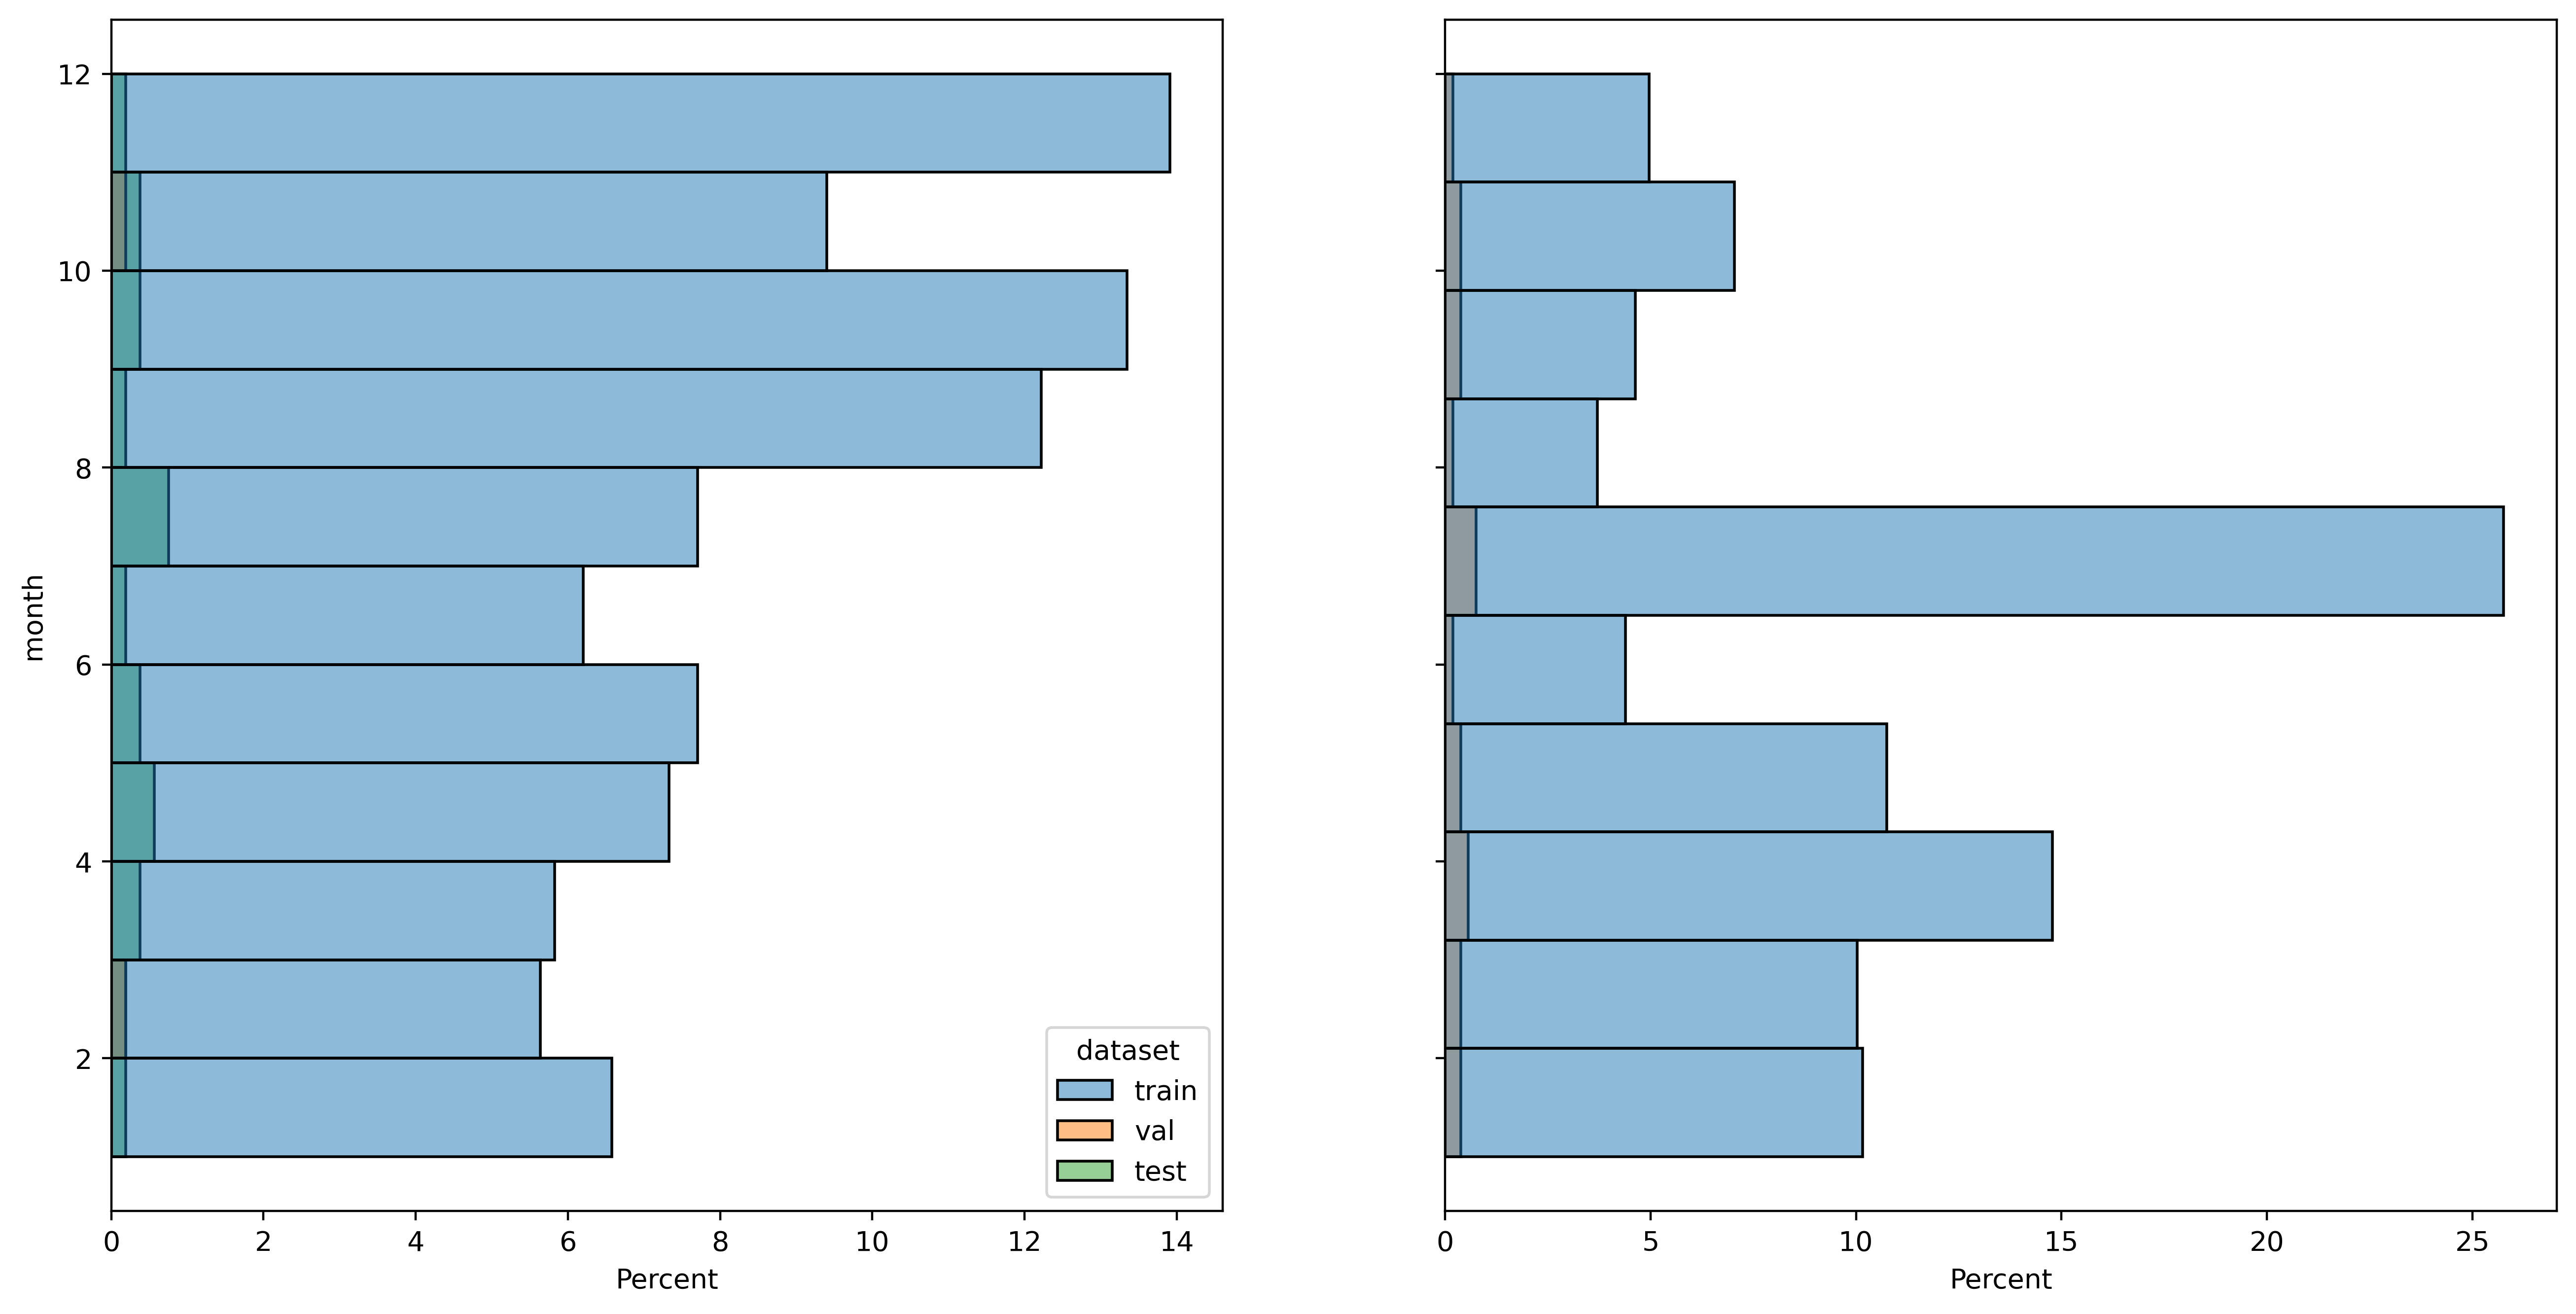

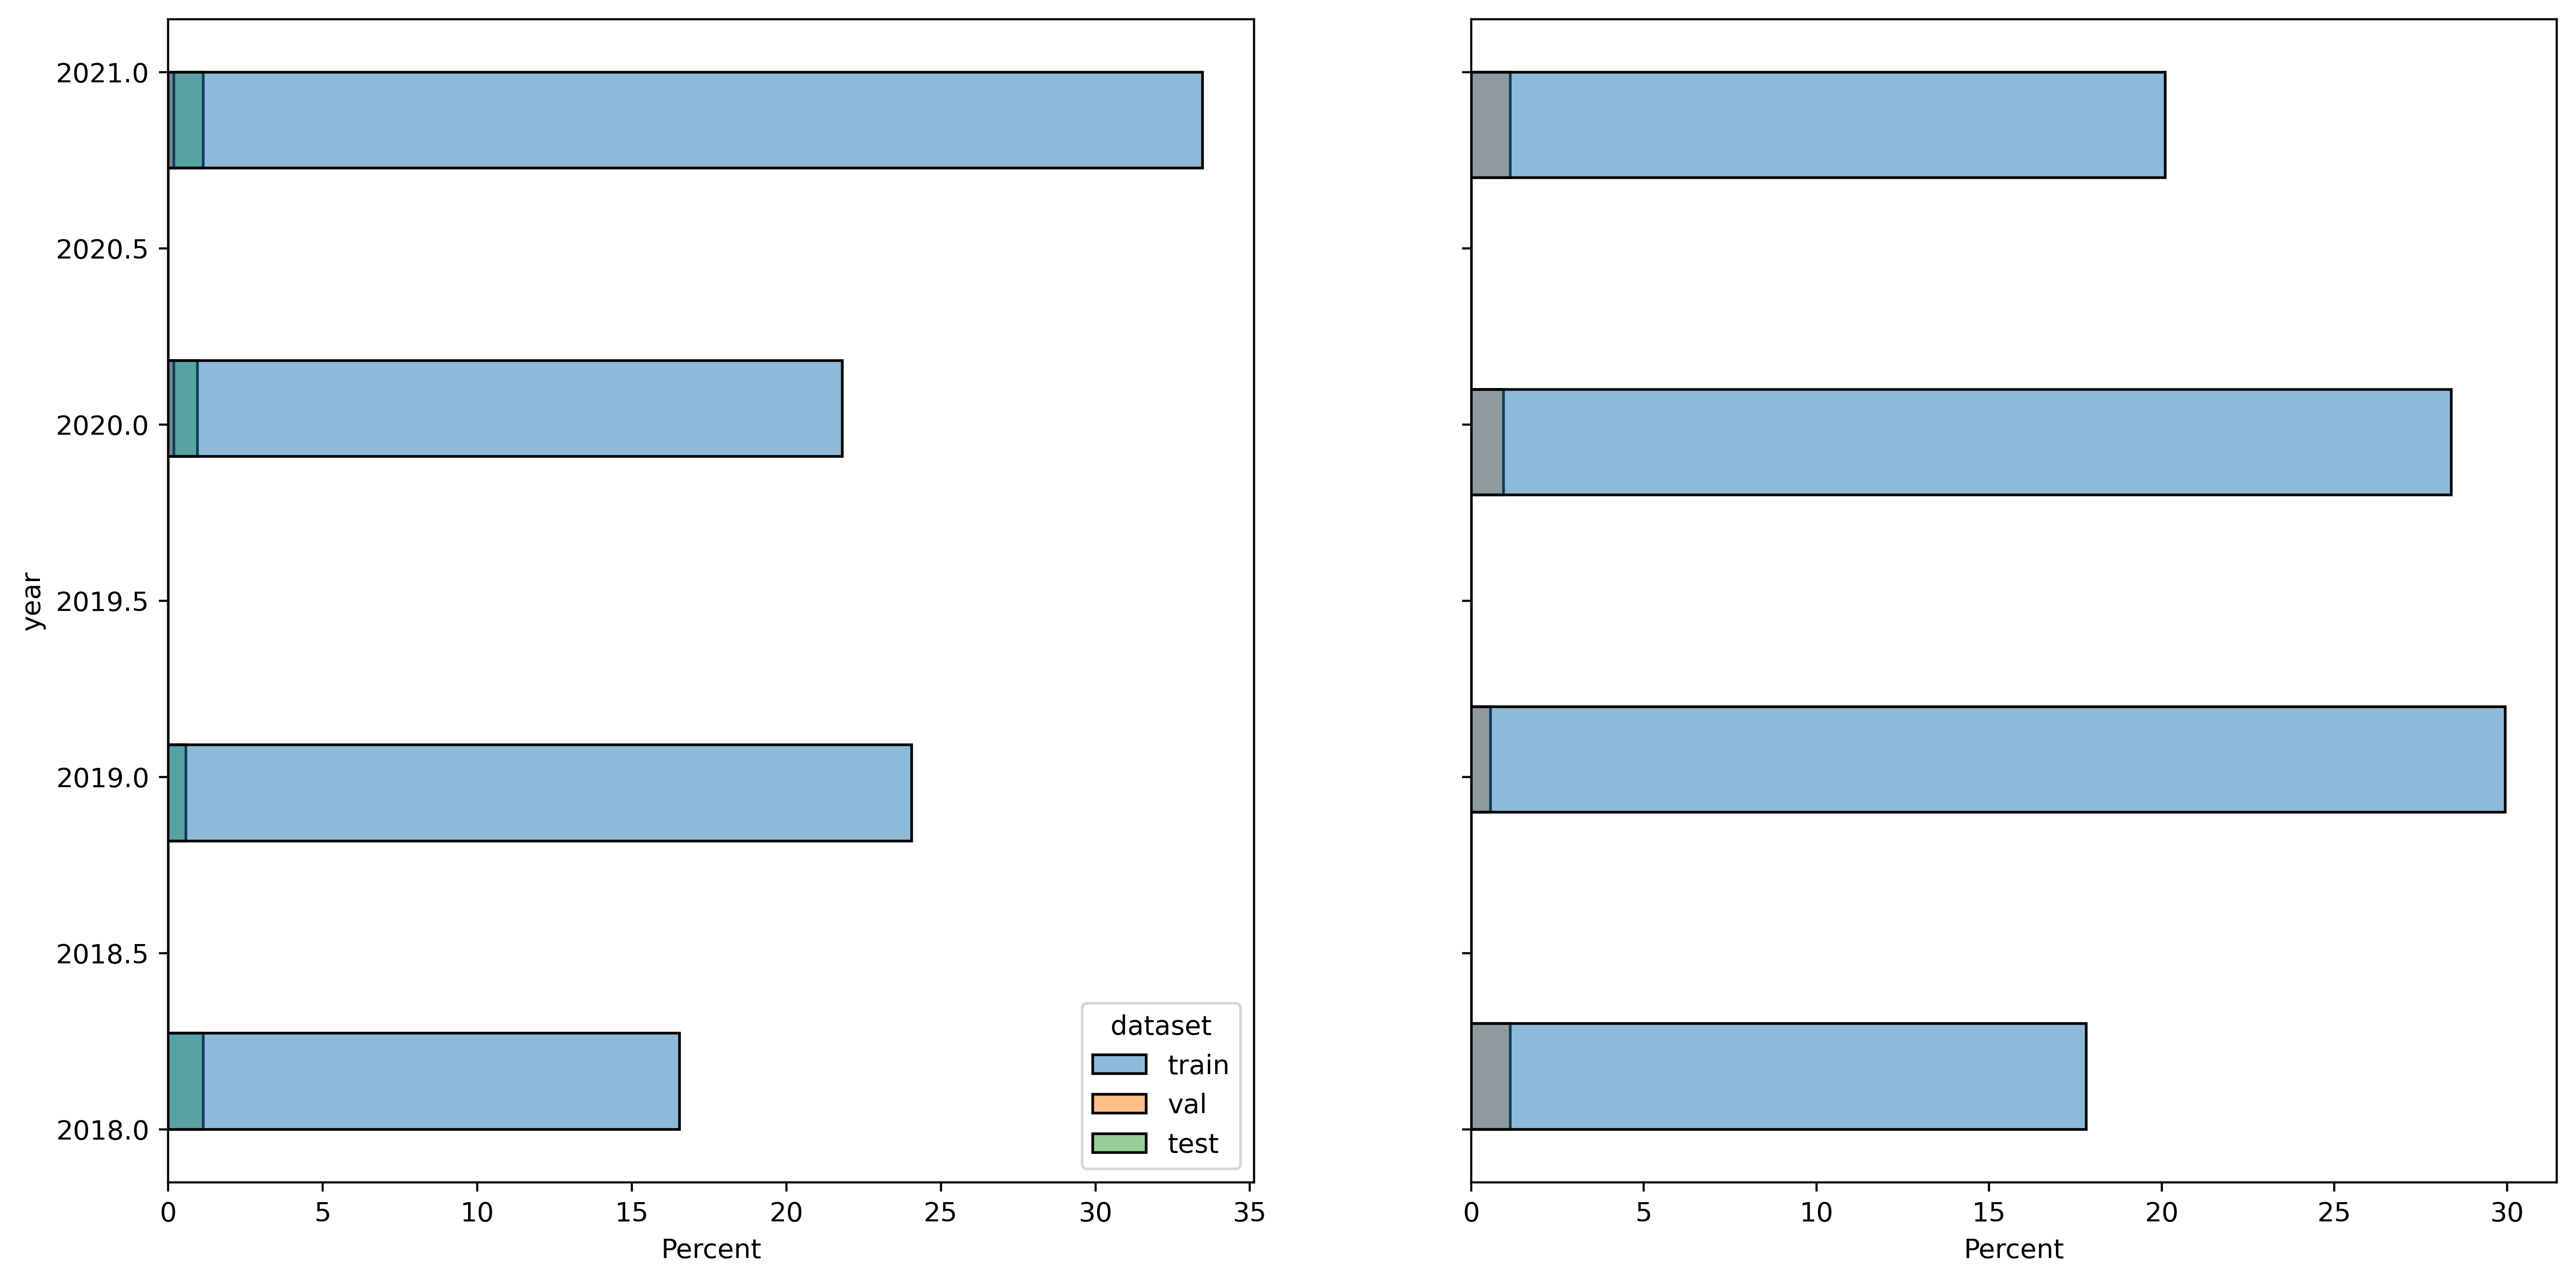

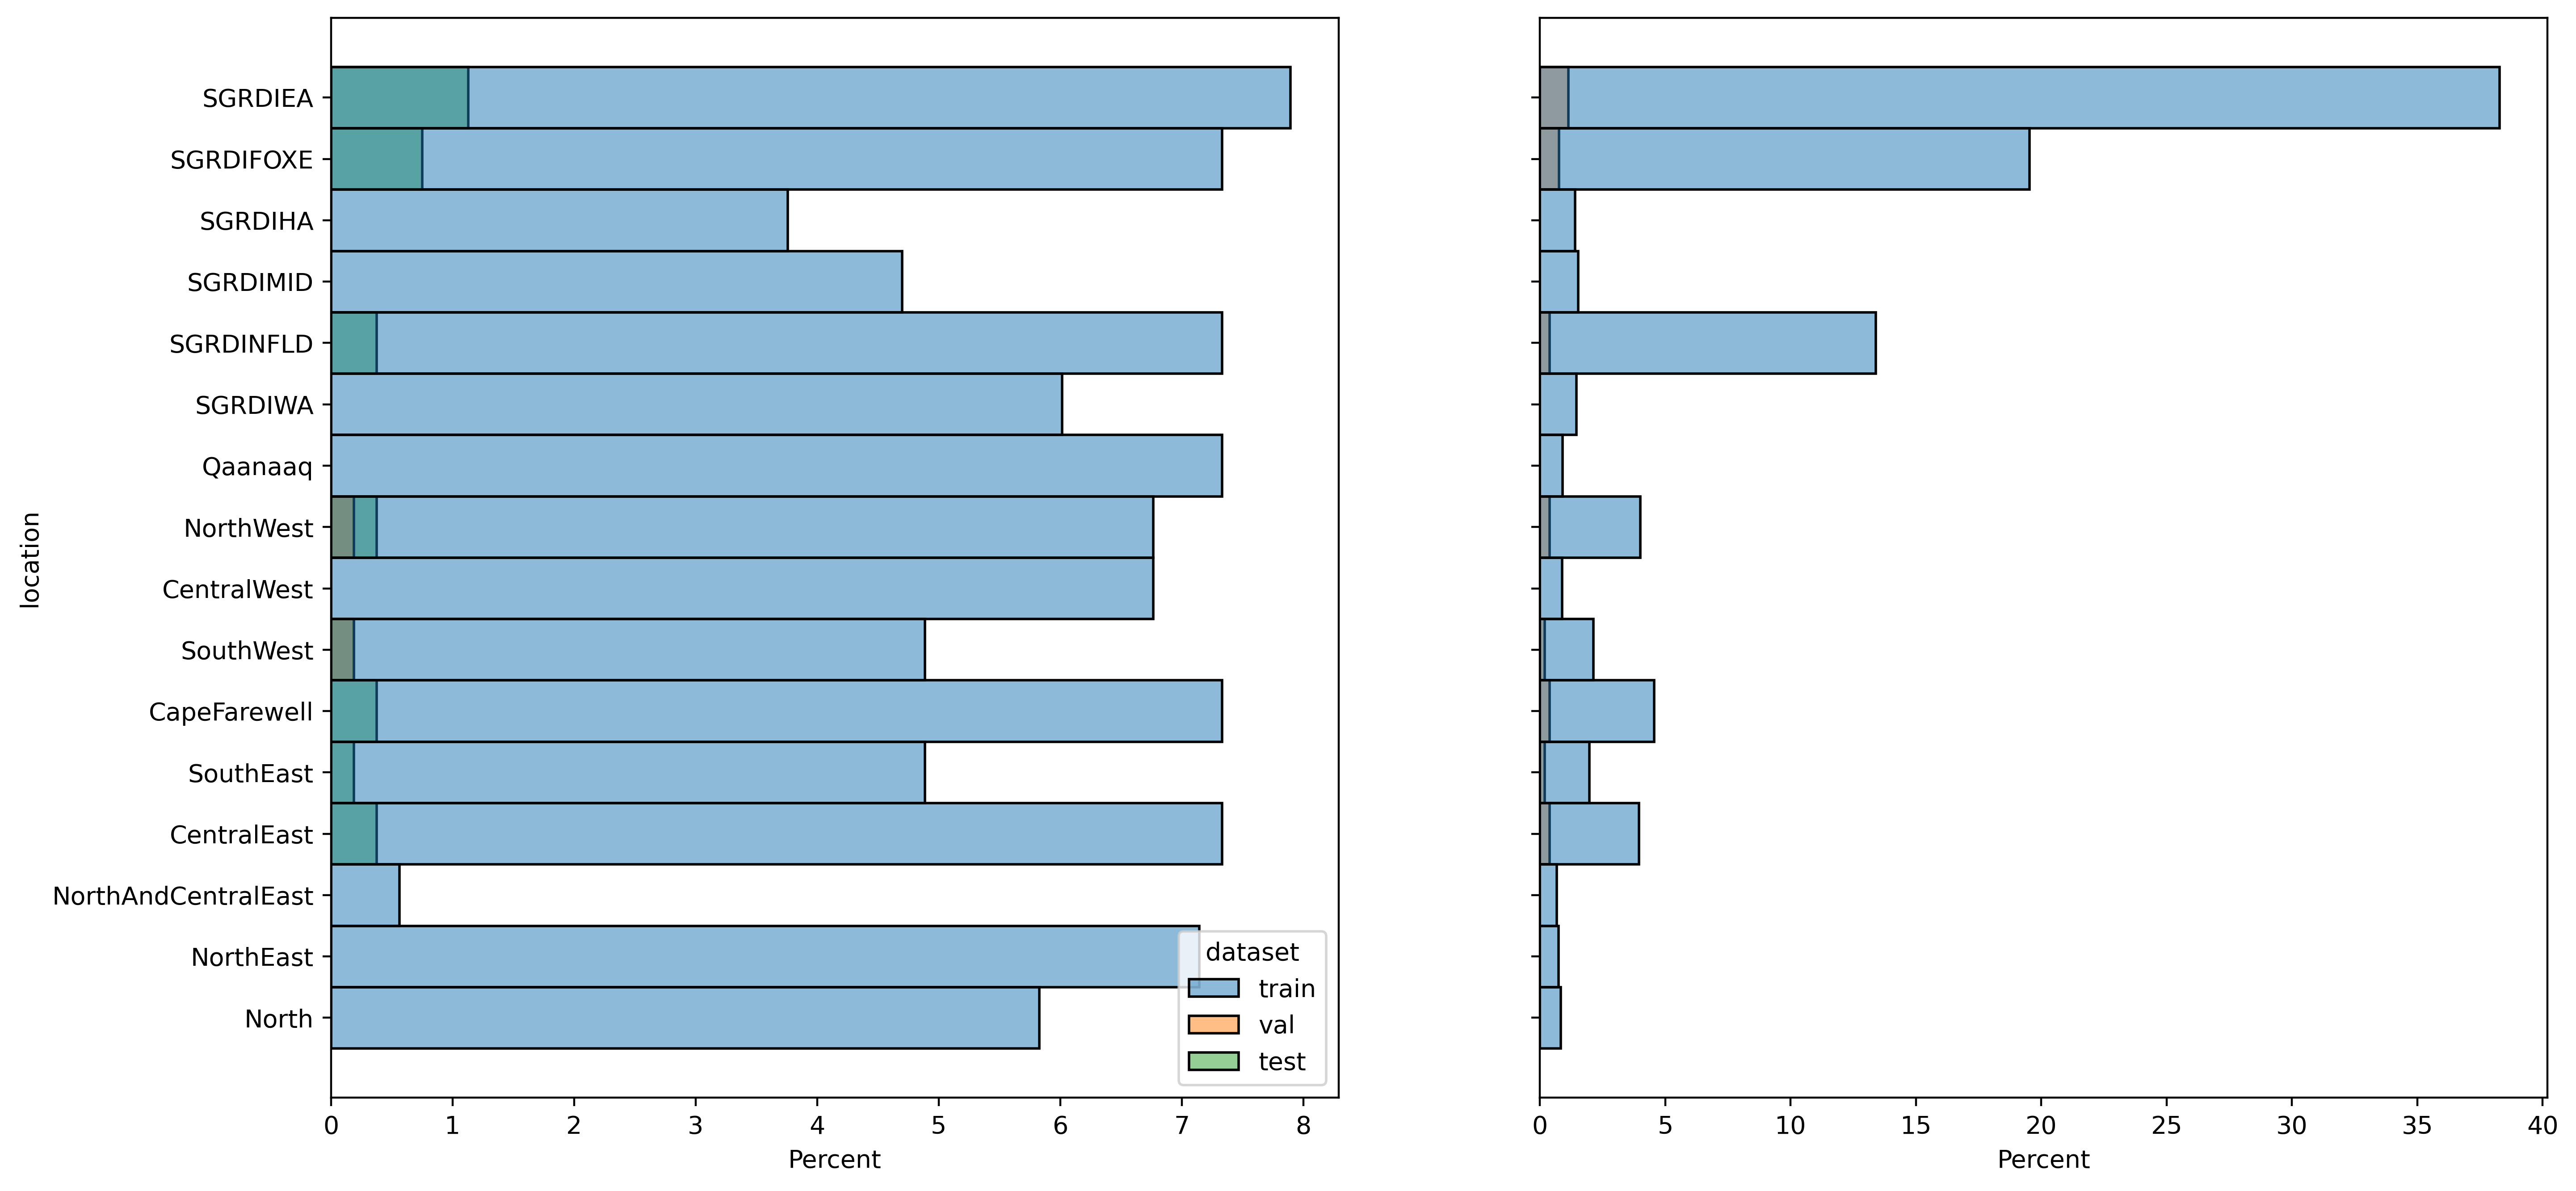

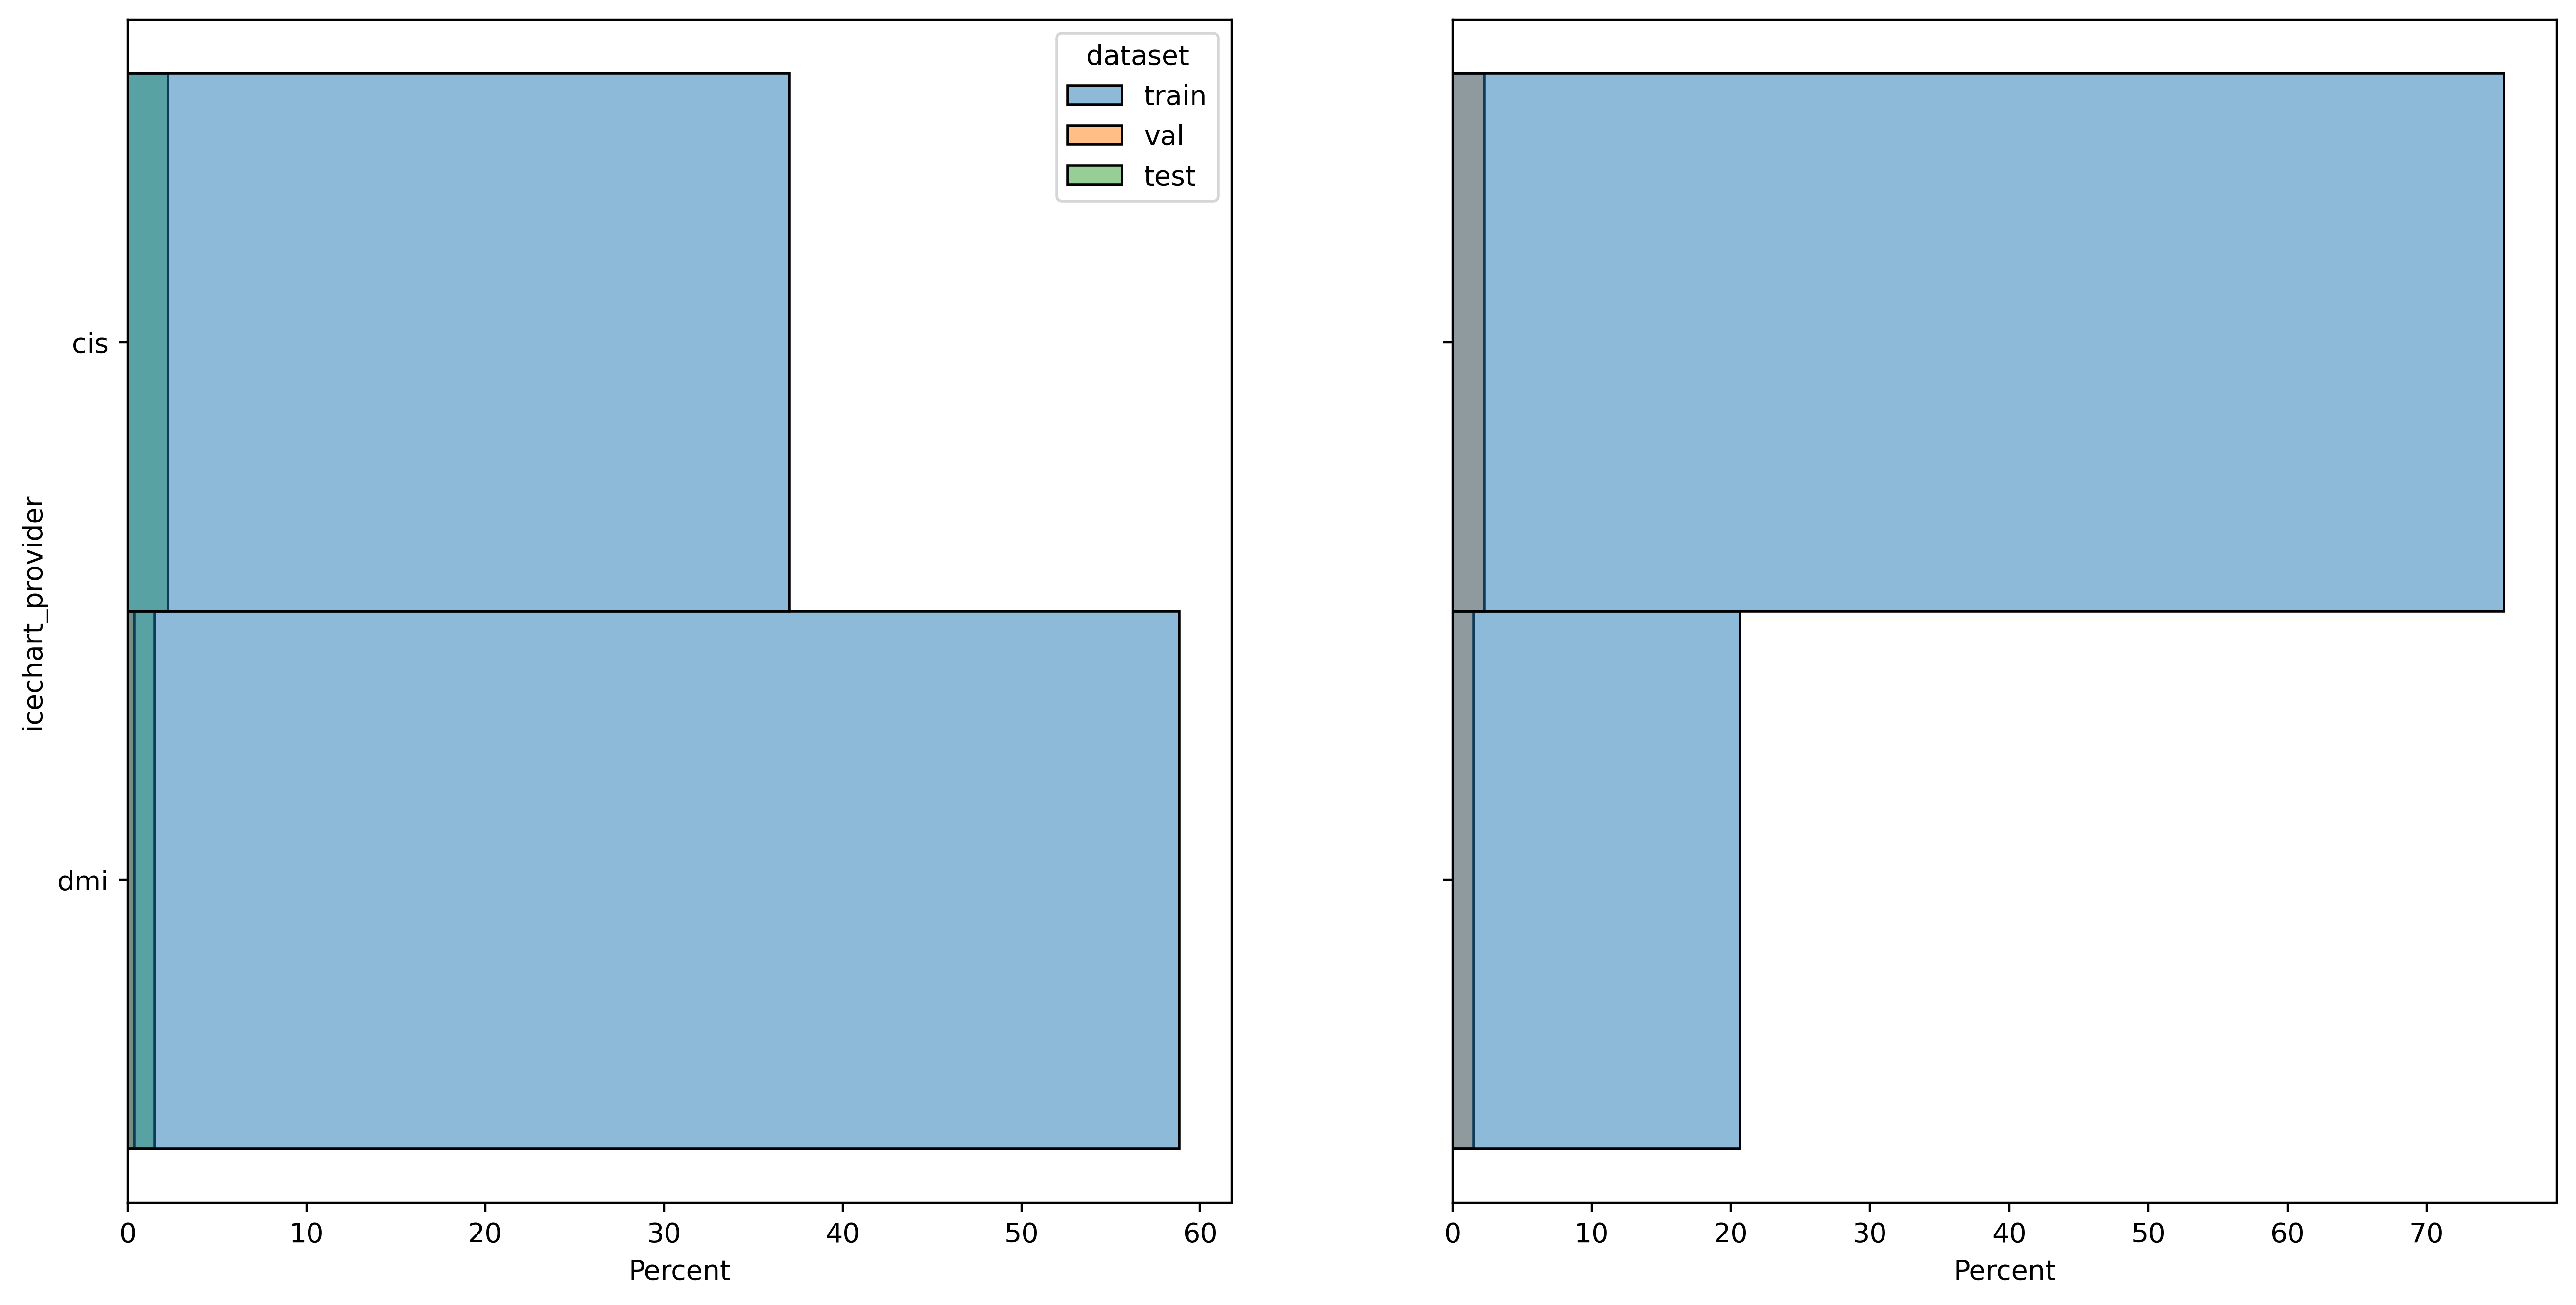

In [3]:
# Get GPU resources.
if torch.cuda.is_available():
    print(colour_str('GPU available!', 'green'))
    print('Total number of available devices: ', colour_str(torch.cuda.device_count(), 'orange'))
    device = torch.device(f"cuda:{train_options['gpu_id']}")

else:
    print(colour_str('GPU not available.', 'red'))
    device = torch.device('cpu')

# Custom dataset and dataloader.
dataset = AI4ArcticChallengeDataset(files=train_options['train_list'], options=train_options, get_metadata=train_options['get_metadata'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=None, shuffle=True, num_workers=train_options['num_workers'], pin_memory=True)
# - Setup of the validation dataset/dataloader. The same is used for model testing in 'test_upload.ipynb'.
dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'], get_metadata=train_options['get_metadata'])
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=None, num_workers=train_options['num_workers_val'], shuffle=False)

print('GPU and data setup complete.')

### Example of Model, optimiser and loss function setup

In [4]:
# Setup U-Net model, adam optimizer, loss function and dataloader.
net = UNet(options=train_options).to(device)
optimizer = torch.optim.Adam(list(net.parameters()), lr=train_options['lr'])
torch.backends.cudnn.benchmark = True  # Selects the kernel with the best performance for the GPU and given input size.

# Loss functions to use for each sea ice parameter.
# The ignore_index argument discounts the masked values, ensuring that the model is not using these pixels to train on.
# It is equivalent to multiplying the loss of the relevant masked pixel with 0.
loss_functions = {chart: torch.nn.CrossEntropyLoss(ignore_index=train_options['class_fill_values'][chart]) \
                                                   for chart in train_options['charts']}
# use regression loss for SIC
if train_options['loss_sic'] == 'regression':
    loss_functions['SIC'] = torch.nn.MSELoss()

print(f"The loss functions used are: {loss_functions}")
print('Model setup complete')

The loss functions used are: {'SIC': CrossEntropyLoss(), 'SOD': CrossEntropyLoss(), 'FLOE': CrossEntropyLoss()}
Model setup complete


## Example of model training and validation loop
A simple model training loop following by a simple validation loop. Validation is carried out on full scenes, i.e. no cropping or stitching. If there is not enough space on the GPU, then try to do it on the cpu. This can be done by using 'net = net.cpu()'.

### Workflow with MLflow

- every model needs to be initiated with start_run() function
- parameters can be logged with log_params() method
- metrics are added with log_metric() with specified name and value
- model can be stored into the model storage as artifact using corresponding flavour
- for using MLflow autologing, model needs to use one of the supported flavours, eg. pytorch-lightning, fastai, tensorflow, xgboost or others - see [full list](https://www.mlflow.org/docs/latest/tracking.html#automatic-logging) 


In [5]:
if not train_options['development']:
    ## setting up the sqlite database for tracking of experiments in MLflow
    mlflow.set_tracking_uri('sqlite:///' + os.path.expanduser(os.environ["MLFLOW_BACKEND_STORE_PATH"]))
    os.path.expanduser(os.environ["MLFLOW_BACKEND_STORE_PATH"])

    ## setting the used experiment - if do not exist, new one will be created
    e = mlflow.set_experiment(train_options['model_codename'])
    e.experiment_id

In [6]:
# implementing an ealy stopper
class EarlyStopper:
    """
    Stops the training early iff the validation loss does not increase anymore more than a small delta.
    As the FLOE is weighted only half as much as the other two, the model does only need to get better half as much there.
    """
    def __init__(self, patience=1, min_delta=0.1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_val_score = -np.inf
        
    def early_stop(self, combined_score, best_combined_score):
        # does not improve enough anymore: < old best + delta
        if combined_score <= (self.max_val_score + self.min_delta):
            self.counter += 1
        else:
            self.max_val_score = best_combined_score # such that there is not a crawling improvement not seen
            self.counter = 0
        return self.counter > self.patience

In [7]:
best_combined_score = 0  # Best weighted model score.
# early_stopper = EarlyStopper(patience = 4, min_delta=0.3)
metadata = pd.DataFrame(columns=['sentinel_mission_identifier',
                                'image_acquisition_start_date',
                                'image_acquisition_start_date_year', 'image_acquisition_start_date_month', 'image_acquisition_start_date_hour',
                                'row_rand', 'col_rand', 'sample_n',
                                'icechart_provider', 'location',
                                'score_SIC', 'score_SOD', 'score_FLOE', 'score_combined',
                                'loss_SIC', 'loss_SOD', 'loss_FLOE', 'loss_combined',
                                'ice_characteristcs_SIC', 'ice_characteristcs_SOD', 'ice_characteristcs_FLOE',
                                'epoch_no', 'type'])

with mlflow.start_run() if not train_options['development'] else nullcontext() as run:
    mlflow.log_params(train_options['chart_metric'])

    # -- Training Loop -- #
    for epoch in tqdm(iterable=range(train_options['epochs']), position=0):
        gc.collect()  # Collect garbage to free memory.
        loss_sum = torch.tensor([0.])  # To sum the batch losses during the epoch.
        net.train()  # Set network to evaluation mode.

        # Loops though batches in queue.
        for i, (batch_x, batch_y, masks, metadata_batch) in enumerate(tqdm(iterable=dataloader, total=train_options['epoch_len'], colour='red', position=0)):
            torch.cuda.empty_cache()  # Empties the GPU cache freeing up memory.
            loss_batch = 0  # Reset from previous batch.

            # - Update metadata
            if train_options['get_metadata']:
                metadata_batch['epoch_no'] = epoch
                metadata_batch['type'] = 'train'
                metadata_batch['score_combined'] = np.nan

            # - Transfer to device.
            batch_x = batch_x.to(device, non_blocking=True)

            # - Mixed precision training. (Saving memory)
            with torch.cuda.amp.autocast():
                # - Forward pass. 
                output = net(batch_x)

                # - Calculate loss.
                for chart in train_options['charts']:
                    # - weight FLOE to balance it with the metrics
                    # TODO: weight SIC loss as it is a different kind of loss?
                    weight = 1 if chart != 'FLOE' else 0.5

                    # - masking for sic loss has to be done here
                    if chart == 'SIC' and train_options['loss_sic'] == 'regression':
                        # - mask out the masked values
                        mask = masks[chart].to(device, non_blocking=True)
                        output[chart] = output[chart][~mask].to(device)
                        batch_y[chart] = batch_y[chart][~mask].float().to(device)

                    loss_temp = weight * loss_functions[chart](input=output[chart], target=batch_y[chart].to(device))
                    if train_options['get_metadata']:
                        metadata_batch[f'loss_{chart}'] = loss_temp.detach().item()
                    loss_batch += loss_temp

                    try:
                        mlflow.log_metric(key="chart_loss", value=loss_batch)
                    except Exception as e:
                        print(f"In epoch {epoch}, batch {i} the following error occured \n {e}")
                        continue

                if train_options['get_metadata']:
                    metadata_batch[f'loss_combined'] = loss_batch.detach().item()

                # - recreate each patch from batch and calculate the metrics for it
                # uses an adapted code from the validation loop below
                # uses an adapted code from the validation loop below
                for j in range(train_options['batch_size']):
                    mask_single_patch = masks[chart][j]

                    output_single_patch_temp = {}
                    for chart in train_options['charts']:
                        if chart == 'SIC' and train_options['loss_sic'] == 'regression':
                            output_single_patch_temp[chart] = output[chart][j].squeeze().cpu().numpy()
                        else:
                            output_single_patch_temp[chart] = torch.argmax(output[chart][j], dim=0).squeeze().cpu().numpy()

                    output_single_patch = {chart: output_single_patch_temp[chart][~mask_single_patch] for chart in train_options['charts']}

                    batch_y_single_patch = {chart: batch_y[chart][j][~mask_single_patch].cpu().numpy() for chart in train_options['charts']}

                    # -- update metadata for each element in the batch = 'sample_n'
                    try:
                        combined_score, scores = compute_metrics(pred=output_single_patch, true=batch_y_single_patch, charts=train_options['charts'],
                                                            metrics=train_options['chart_metric'])
                    except ValueError as e:
                        scores = {chart: np.nan for chart in train_options['charts']}
                        combined_score = np.nan
                        print(f"Error in computing metrics for sample {j} in batch {i} in epoch {epoch}, {e}")
                        continue

                    for chart in train_options['charts']:
                        # because the index should be the same as the sample_n
                        metadata_batch.loc[(j, 'score_' + chart)] = scores[chart]
                        metadata_batch.loc[(j, 'ice_characteristcs_' + chart)] = float(torch.median(batch_y[chart]))
                    metadata_batch.loc[(j, 'score_combined')] = combined_score

                    del mask_single_patch, batch_y_single_patch, output_single_patch, output_single_patch_temp, combined_score, scores


            # - Reset gradients from previous pass.
            optimizer.zero_grad()

            # - Backward pass.
            loss_batch.backward()

            # - Optimizer step
            optimizer.step()

            # - Add batch loss.
            loss_sum += loss_batch.detach().item()

            # - Average loss for displaying
            loss_epoch = torch.true_divide(loss_sum, i + 1).detach().item()
            print('\rMean training loss: ' + f'{loss_epoch:.3f}', end='\r')

            # - update metdata
            metadata = pd.concat([metadata, metadata_batch], ignore_index=True)

            # - Log metrics to MLflow
            try:
                mlflow.log_metric(key="mean_loss", value=loss_epoch)
            except Exception as e:
                print(f"In epoch {epoch}, batch {i} the following error occured \n {e}")
                continue
            del output, batch_x, batch_y, masks, metadata_batch # Free memory.
        del loss_sum

        # -- Validation Loop -- #
        loss_batch = loss_batch.detach().item()  # For printing after the validation loop.

        # - Stores the output and the reference pixels to calculate the scores after inference on all the scenes.
        outputs_flat = {chart: np.array([]) for chart in train_options['charts']}
        inf_ys_flat = {chart: np.array([]) for chart in train_options['charts']}

        net.eval()  # Set network to evaluation mode.
        # - Loops though scenes in queue.
        for inf_x, inf_y, masks, name, metadata_scene in tqdm(iterable=dataloader_val, total=len(train_options['validate_list']), colour='green', position=0):
            torch.cuda.empty_cache()
            gc.collect()

            # - update metadata
            if train_options['get_metadata']:
                metadata_scene['epoch_no'] = epoch
                metadata_scene['type'] = 'test'
                outputs_scene, inf_ys_scene = {}, {}

            # - crop the test scene to save memory in development mode
            if train_options['development']:
                # if we only take the border we get only masked values
                crop_start = 1000
                crop_size = 300
                crop_idx = slice(crop_start, crop_start + crop_size)
                inf_x = inf_x[:, :, crop_idx, crop_idx]
                inf_y = {chart: inf_y[chart][crop_idx, crop_idx] for chart in train_options['charts']}
                masks = {chart: masks[chart][crop_idx, crop_idx] for chart in train_options['charts']}

            # - Ensures that no gradients are calculated, which otherwise take up a lot of space on the GPU.
            with torch.no_grad(), torch.cuda.amp.autocast():
                inf_x = inf_x.to(device, non_blocking=True)
                output = net(inf_x)

            # - Final output layer, and storing of non masked pixels.
            for chart in train_options['charts']:
                if chart == 'SIC' and train_options['loss_sic'] == 'regression':
                    output[chart] = output[chart].squeeze().cpu().numpy()
                else:
                    output[chart] = torch.argmax(output[chart], dim=1).squeeze().cpu().numpy()
                outputs_flat[chart] = np.append(outputs_flat[chart], output[chart][~masks[chart]])
                inf_ys_flat[chart] = np.append(inf_ys_flat[chart], inf_y[chart][~masks[chart]].numpy())

                # - calculate the median values for each scene
                if train_options['get_metadata']:
                    outputs_scene[chart] = output[chart][~masks[chart]]
                    inf_ys_scene[chart] = inf_y[chart][~masks[chart]].numpy()

                    # in development mode it is possible that every value of the scene is masked
                    # this is only possible for the test scenes, because the training dataloader makes sure that there are not too many masked values
                    if np.all(~masks[chart].numpy() == False):
                        print(f"There are no unmasked values in {chart} of {name}.")
                        outputs_scene[chart], inf_ys_scene[chart] = np.nan, np.nan

            # - update metadata
            if train_options['get_metadata']:
                for chart in train_options['charts']:
                    metadata_scene[f'score_{chart}'] = np.median(outputs_scene[chart])
                    metadata_scene[f'ice_characteristcs_{chart}'] = np.median(inf_ys_scene[chart])

                combined_score_scene, scores_scene = compute_metrics(true=inf_ys_scene, pred=outputs_scene, charts=train_options['charts'],
                                                                     metrics=train_options['chart_metric'])
                metadata_scene['score_combined'] = combined_score_scene
                metadata = pd.concat([metadata, metadata_scene], ignore_index=True)

            del inf_x, inf_y, masks, name, metadata_scene, output, combined_score_scene, scores_scene  # Free memory.

        # - Compute the relevant scores.
        combined_score, scores = compute_metrics(true=inf_ys_flat, pred=outputs_flat, charts=train_options['charts'],
                                                 metrics=train_options['chart_metric'])

        print("")
        print(f"Final batch loss: {loss_batch:.3f}")
        print(f"Epoch {epoch} score:")
        for chart in train_options['charts']:
            print(f"{chart} {train_options['chart_metric'][chart]['func'].__name__}: {scores[chart]}%")
        print(f"Combined score: {combined_score}%")
        
        try:
            mlflow.log_metric(key="final_batch_loss", value=loss_batch)
            mlflow.log_metric(key="combined_score", value=combined_score)
        except Exception as e:
            print(f"In epoch {epoch}, batch {i} the following error occured \n {e}")
            continue

        # If the scores is better than the previous epoch, then save the model and rename the image to best_validation.
        if combined_score > best_combined_score:
            best_combined_score = combined_score
            torch.save(obj={'model_state_dict': net.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'epoch': epoch},
                            f=f"models/{train_options['model_codename']}_{epoch}_best_model")
        elif epoch % 25 == 0:
            torch.save(obj={'model_state_dict': net.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'epoch': epoch},
                            f=f"models/{train_options['model_codename']}_{epoch}_model")
        # elif early_stopper(combined_score, best_combined_score):
        #     break
            
        del inf_ys_flat, outputs_flat  # Free memory.

# - Save the metadata
if train_options['get_metadata']:
    metadata.to_csv(os.path.join(train_options['path_to_env'], f"metadata_runs/{train_options['model_codename']}_metadata.csv"))

# - Log the metadata as an artifact
if train_options['get_metadata']:
    try:
        mlflow.log_artifact(f"metadata_runs/{train_options['model_codename']}_metadata.csv")
    except Exception as e:
        print(f"While logging the metadata the following error occured \n {e}")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

/home/work/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


/home/work/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


  0%|          | 0/2 [00:00<?, ?it/s]

/home/work/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
/home/work/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")



Final batch loss: 5.651
Epoch 0 score:
SIC r2_metric: 58.848%
SOD f1_metric: 0.0%
FLOE f1_metric: 0.0%
Combined score: 23.539%


  0%|          | 0/2 [00:00<?, ?it/s]

/home/work/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


/home/work/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


  0%|          | 0/2 [00:00<?, ?it/s]

/home/work/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
/home/work/.local/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")



Final batch loss: 5.601
Epoch 1 score:
SIC r2_metric: -7.038%
SOD f1_metric: 0.0%
FLOE f1_metric: 0.0%
Combined score: -2.815%


In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(metadata[metadata['type'] == 'test'])

,sentinel_mission_identifier,image_acquisition_start_date,image_acquisition_start_date_year,image_acquisition_start_date_month,image_acquisition_start_date_hour,row_rand,col_rand,sample_n,icechart_provider,location,score_SIC,score_SOD,score_FLOE,score_combined,loss_SIC,loss_SOD,loss_FLOE,loss_combined,ice_characteristcs_SIC,ice_characteristcs_SOD,ice_characteristcs_FLOE,epoch_no,type
4,S1B,2021-02-02 21:18:45,2021,2,21,NaN,NaN,NaN,dmi,SouthWest,10.0,5.0,3.0,0.0,NaN,NaN,NaN,NaN,10.0,4.0,5.0,0,test
5,S1B,2020-10-07 21:03:52,2020,10,21,NaN,NaN,NaN,dmi,NorthWest,4.0,5.0,3.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,test
10,S1B,2021-02-02 21:18:45,2021,2,21,NaN,NaN,NaN,dmi,SouthWest,4.0,5.0,3.0,0.0,NaN,NaN,NaN,NaN,10.0,4.0,5.0,1,test
11,S1B,2020-10-07 21:03:52,2020,10,21,NaN,NaN,NaN,dmi,NorthWest,4.0,5.0,3.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1,test
